# Quiz

In [1]:
import turicreate as tc

In [2]:
image_train = tc.SFrame("data/image_train_data")
image_test  = tc.SFrame("data/image_test_data")

## Task 1: Compute summary statistics of the data

In [3]:
sketch = tc.Sketch(image_train['label'])

In [19]:
image_train['label'].unique()

dtype: str
Rows: 4
['bird', 'dog', 'cat', 'automobile']

In [18]:
# frequent_items() only returns the most frequent items
# however, because there are merely 4 items, we dont need more steps
sketch.frequent_items()

{'bird': 478, 'cat': 509, 'dog': 509, 'automobile': 509}

## Task 2: Create category-specific image retrieval models

In [42]:
def create_knn_model(label):
    sf = image_train[image_train['label'] == label]
    knn_model = tc.nearest_neighbors.create(sf, features = ['deep_features'], label = 'id')
    return sf, knn_model

In [43]:
dog_sf, dog_model = create_knn_model('dog')

Starting brute force nearest neighbors model training.

In [44]:
cat_sf, cat_model = create_knn_model('cat')

Starting brute force nearest neighbors model training.

In [45]:
bird_sf, bird_model = create_knn_model('bird')

Starting brute force nearest neighbors model training.

In [46]:
automobile_sf, automobile_model = create_knn_model('automobile')

Starting brute force nearest neighbors model training.

In [39]:
first_cat_image = image_test[0:1]

In [56]:
cats_nn = cat_model.query(first_cat_image)

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.196464    | 5.708ms      |

| Done         |         | 100         | 36.415ms     |

+--------------+---------+-------------+--------------+

In [57]:
cats_nn.head(1)

query_label,reference_label,distance,rank
0,16289,34.62371920804245,1


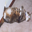

In [78]:
cat_sf[cat_sf['id'] == 16289]['image'][0]

In [53]:
dogs_nn = dog_model.query(first_cat_image)

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.196464    | 5.125ms      |

| Done         |         | 100         | 29.823ms     |

+--------------+---------+-------------+--------------+

In [54]:
dogs_nn.head(1)

query_label,reference_label,distance,rank
0,16976,37.464262878423774,1


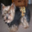

In [79]:
dog_sf[dog_sf['id'] == 16976]['image'][0]

## Task 3: Try a simple example of nearest-neighbors classification

In [59]:
cats_nn[0:5]['distance'].mean()

36.15573070978294

In [60]:
dogs_nn[0:5]['distance'].mean()

37.77071136184157

## Task 4: Compute nearest neighbors accuracy

In [61]:
image_test_cat = image_test[image_test['label'] == 'cat']

image_test_dog = image_test[image_test['label'] == 'dog']

image_test_bird = image_test[image_test['label'] == 'bird']

image_test_automobile = image_test[image_test['label'] == 'automobile']

In [67]:
dog_cat_neighbors = cat_model.query(image_test_dog, k=1)

dog_automobile_neighbors = automobile_model.query(image_test_dog, k=1)

dog_bird_neighbors = bird_model.query(image_test_dog, k=1)

dog_dog_neighbors = dog_model.query(image_test_dog, k=1)

Starting blockwise querying.

max rows per data block: 4348

number of reference data blocks: 8

number of query data blocks: 1

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 1000         | 64000   | 12.5737     | 298.455ms    |

| Done         | 509000  | 100         | 363.165ms    |

+--------------+---------+-------------+--------------+

In [71]:
sf = tc.SFrame({
    "dog-dog": dog_dog_neighbors['distance'],
    "dog-cat": dog_cat_neighbors['distance'],
    "dog-automobile": dog_automobile_neighbors['distance'],
    "dog-bird": dog_bird_neighbors['distance']
})

In [73]:
def is_dog_correct(row):
    return ((row['dog-dog'] < row['dog-cat']) 
            and (row['dog-dog'] < row['dog-automobile'])
            and (row['dog-dog'] < row['dog-bird']))

In [74]:
sf['correct'] = sf.apply(is_dog_correct)

In [80]:
sf['correct'].sum() / sf.shape[0]

0.678